<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/imageGenerationUsingGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Generation using Generative Adversarial Networks

In [75]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
device

'cuda'

In [77]:
!pip install jovian --upgrade -q
import jovian
jovian.__version__

'0.2.45'

In [78]:
#jovian.utils.colab.set_colab_file_id('1Bz0oJP4zOfTu3Zd2QhFAvY0EXj_119E6')

## Approach towards GAN

Random input vector -> Generator Model -> Generated Example

Generated Example + Real Example -> Discriminator Model -> Binary Classification (real/fake) -> update discriminator model + generator model 

1. train the discriminator model to distinguish between really bad generator images and real images (binary classification model)
2. train the generator model for a few epochs to create better fakes 
3. repeat 1&2 over and over




## Use Anime Face Dataset

consists of 63,000 cropped anime faces - unsupervised and so these images do not have labels


### get dataset from kaggle

use opendatasets library to download kaggle dataset
1. sign in to kaggle and click on profile picture and select my account
2. scroll down to API and click create new API Token this will download a file kaggle.json 
3. when you run `opendatasets.download` you will be asked to enter your username & kaggle API which you get from previous file

In [79]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od 

In [80]:
import os 
from pathlib import Path

DATA_DIR = './animefacedataset'
DATA_PATH = Path(DATA_DIR)

In [81]:
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
if not DATA_PATH.is_dir():
  od.download(dataset_url)
  print(f"{DATA_PATH} doesn't exist, creating one...")
else:
  print(f"{DATA_PATH} already exists, skipping download...")

animefacedataset already exists, skipping download...


In [82]:
print(os.listdir(DATA_DIR))


['images']


In [83]:
print(os.listdir(DATA_DIR+'/images')[:10])

['1768_2001.jpg', '32884_2011.jpg', '22634_2008.jpg', '18866_2007.jpg', '20944_2008.jpg', '49173_2015.jpg', '43497_2013.jpg', '32338_2011.jpg', '15052_2006.jpg', '15514_2006.jpg']


### loading dataset

loading dataset using `ImageFolder` class from `torchvision` 
We will also resize and crop the images to 64x64
normalize all pixel values with a mean & std dev of 0.5 for each channel (will ensure that all pixel values are in the range (-1, 1)) which is more convenient for training and discriminator
create data loader to load the bathces in batches

In [84]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [85]:
imageSize = 64
batchSize = 128 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
numWorkers = os.cpu_count()

In [86]:
transform = T.Compose([
    T.Resize(imageSize),
    T.CenterCrop(imageSize), 
    T.ToTensor(),
    T.Normalize(*stats)
])

trainData = ImageFolder(root=DATA_DIR,
                        transform=transform)

trainDataLoader = DataLoader(dataset=trainData,
                             batch_size=batchSize,
                             shuffle=True,
                             num_workers=numWorkers,
                             pin_memory=True)

create helper functions to denormalize the image tensors and display some sample images from training batch

In [87]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
def denorm(imgTensors):
  """
  takes image tensors that have been normalized between -1 and 1 - returns them 
  to the range 0 and 1
  """
  return imgTensors*stats[1][0] + stats[0][0]

In [89]:
def showImages(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrows=8).permute(1, 2, 0)) # permute used to change color channels last

def showBatch(dataLoader, nmax=64):
  for images, _ in dataLoader:
    showImages(images, nmax)
    break

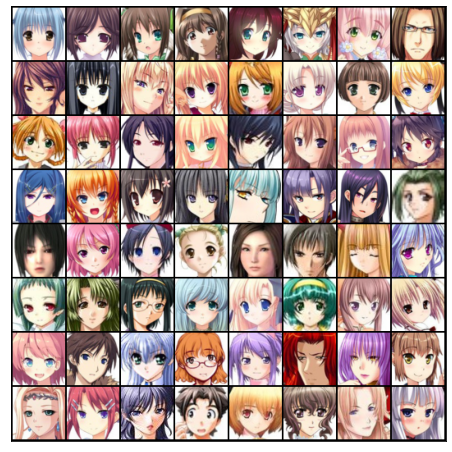

In [90]:
showBatch(trainDataLoader)

In [91]:
class DeviceDataLoader():
  """
  Wrap a dataloader to move data to a device 
  """
  def __init__(self, dataLoader, device):
    self.dataLoader = dataLoader
    self.device = device 
  
  def __iter__(self):
    """
    Yield a batch of data after moving it to device
    """
    for b in self.dataLoader: 
      yield toDevice(b, self.device)

  def __len__(self):
    """
    number of batches
    """
    return len(self.dataLoader)

def toDevice(data, device):
  """
  Move tensors to device 
  """
  if isinstance(data, (list, tuple)):
    return [toDevice(x, device) for x in data]
  else: 
    return data.to(device, non_blocking=True)


In [92]:
device

'cuda'

In [93]:
# sends all data to device 
trainDataLoader = DeviceDataLoader(trainDataLoader, device)

In [94]:
import torch.nn as nn

Discriminator takes an image and tries to classify whether it is a fake or real image. Binary classification!


also, LeakReLU -> (Leaky rectified linear unit) activation for discriminator; use this because it makes the gradients from the discriminator to flow stronger into the generator? - instead of passing a gradient of 0 in the back-prop, it passes a small negative number 

Sigmoid function -> intepret output as a probability; in past models I apply this after the model but it also works to include in model - some loss functions ask for logits but for binary classification, possibly not? 

In [113]:
discriminator = nn.Sequential(
    # in: 3 X 64 X 64
    nn.Conv2d(in_channels=3,
              out_channels=64,
              kernel_size=4,
              stride=2,
              padding=1,
              bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 64 X 32 X 32

    nn.Conv2d(in_channels=64,
              out_channels=128, 
              kernel_size=4,
              stride=2,
              padding=1,
              bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(in_channels=128,
              out_channels=256,
              kernel_size=4,
              stride=2,
              padding=1,
              bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(in_channels=256,
              out_channels=512,
              kernel_size=4, 
              stride=2,
              padding=1,
              bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(in_channels=512,
              out_channels=1,
              kernel_size=4,
              stride=1,
              padding=0,
              bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [114]:
discriminator = toDevice(discriminator, device)

### Generator Network 

The input to the generator is a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128,1,1)` into an image tensor of shape `(3x64x64)`. To acheive this, we'll use the `ConvTranspose2d` layer from PyTorch, which performs a transposed convolution - also called deconvolution

In [115]:
latentSize = 128

In [116]:
generator = nn.Sequential(
    # in: latentSize x 1 x 1

    nn.ConvTranspose2d(in_channels=latentSize,
                       out_channels=512,
                       kernel_size=4,
                       stride=1,
                       padding=0,
                       bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(inplace=True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512,
                       out_channels=256,
                       kernel_size=4,
                       stride=2,
                       padding=1,
                       bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(inplace=True), 
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256,
                       out_channels=128,
                       kernel_size=4,
                       stride=2,
                       padding=1,
                       bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128,
                       out_channels=64,
                       kernel_size=4,
                       stride=2,
                       padding=1,
                       bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64,
                       out_channels=3,
                       kernel_size=4,
                       stride=2,
                       padding=1,
                       bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Tanh -> reduces numbers into range -1 to 1 -> so outputs of generator can be images with right range 

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


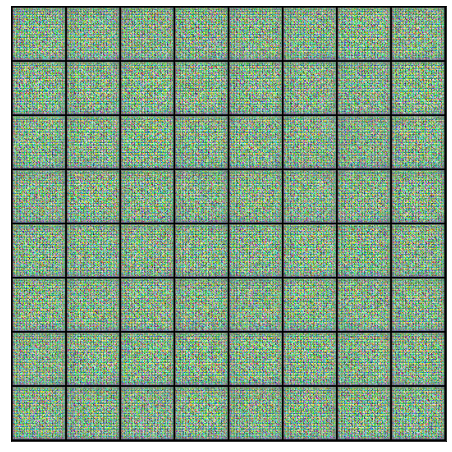

In [117]:
# create random latent tensors
xb = torch.randn(batchSize, latentSize, 1, 1)
print(xb.shape)
fakeImages = generator(xb)
print(fakeImages.shape)
showImages(fakeImages)

In [118]:
# send generator to device
generator = toDevice(generator, device)

## Discriminator Training

Binary cross entropy loss function to quantify how well it is able to differentiate

In [131]:
def trainDiscriminator(realImages, # a batch of real images
                       optimizerD): # optimizer

  # clear discriminator gradients
  optimizerD.zero_grad()

  # set discriminator model into train 
  discriminator.train()

  # # set generator model into eval
  # generator.eval()

  # pass real images through discriminator 
  realPreds = discriminator(realImages)
  realTargets = torch.ones(realImages.size(0), 1, device=device)  # set up tensor with same shape as batch size of all ones
  RealLossFn = nn.BCELoss()
  realLoss = RealLossFn(realPreds, realTargets)
  realScore = torch.mean(realPreds).item() # find mean - if perfect this would equal batch size

  # generate fake images 
  latent = torch.randn(batchSize, latentSize, 1, 1, device=device)
  fakeImages = generator(latent)

  # pass fake images through discriminator 
  fakePreds = discriminator(fakeImages)
  fakeTargets = torch.zeros(fakeImages.size(0), 1, device=device)
  fakeLossFn = nn.BCELoss()
  fakeLoss = fakeLossFn(fakePreds, fakeTargets)
  fakeScore = torch.mean(fakePreds).item() # if perfect this would equal 0 

  # update discriminator weights 
  totalLoss = realLoss + fakeLoss 
  totalLoss.backward() 

  # step optimizer
  optimizerD.step()

  return totalLoss.item(), realScore, fakeScore


Steps involved in training the discriminator:
1. expect the discriminator to output 1 if the image was picked from real dataset and 0 if it was generated by the generator network
2. we first pass a batch of real images, setting target to 1
3. we pass fake images setting target to 0 
4. add losses and perform gradient descent to adjust the weights of the discriminator 

### Generator Training 

1. generate a batch of images using the generator, pass this to the discriminator
2. calculate the loss by setting the target labels to 1 i.e. real. We want the generator to fool the discriminator
3. we use the loss to perform gradient descient i.e. change the weights of the generator so it gets better at generating real-like images to fool the discrimnator

In [132]:
def trainGenerator(optimizerG): # generator optimizer 
  # clear generator gradients
  optimizerG.zero_grad()

  # set generator to train
  generator.train() 

  # # set discriminator to eval
  # discriminator.eval()

  # generate fake images
  latent = torch.randn(batchSize, latentSize, 1, 1, device=device)
  fakeImages = generator(latent)

  # try to fool discriminator 
  preds = discriminator(fakeImages)
  targets = torch.ones(batchSize, 1, device=device)
  lossFn = nn.BCELoss()
  loss = lossFn(preds, targets)

  # update generator weights
  loss.backward()

  # step optimizer
  optimizerG.step()

  return loss.item()

create a directory where we can save intermediate outputs from the generator to visually inspect progress of model. we'll create a helpfer function to export the generated images

In [121]:
from torchvision.utils import save_image as saveImage

In [122]:
sampleDir = 'generated'
os.makedirs(sampleDir, exist_ok=True)

In [123]:
def saveSamples(index, latentTensors, show=True):
  fakeImages = generator(latentTensors)
  fakeFname = 'genearted-images-{0:0=4d}.png'.format(index)
  saveImage(denorm(fakeImages), os.path.join(sampleDir, fakeFname), nrow=8)
  print('Saving', fakeFname)
  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fakeImages.cpu().detach(), nrow=8).permute(1,2,0))

In [124]:
fixedLatent = torch.randn(64, latentSize, 1, 1, device=device)

Saving genearted-inages-0000.png


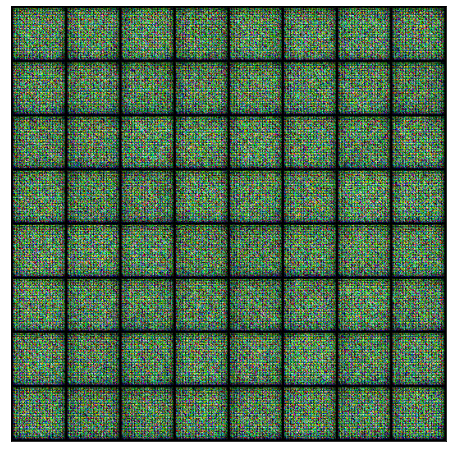

In [125]:
saveSamples(0, fixedLatent)

In [126]:
from tqdm.auto import tqdm 

In [127]:
def fit(epochs, lr, startIDX =1):
  torch.cuda.empty_cache()

  # losses & scores
  lossesG = []
  lossesD = []
  realScores = []
  fakeScores = []

  # create optimizers
  optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for realImages, _ in tqdm(trainDataLoader):

      # train discriminator 
      lossD, realScore, fakeScore = trainDiscriminator(realImages, optimizerD)

      # train generator
      lossG = trainGenerator(optimizerG)

    # record losses & scores
    lossesG.append(lossG)
    lossesD.append(lossD)
    realScores.append(realScore)
    fakeScores.append(fakeScore)

    # log losses and scores (last batch)
    print("Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f}",
          (epoch+1, epochs, lossG, lossD, realScore, fakeScore))
    
    # save generated images
    saveSamples(epoch+startIDX, fixedLatent, show=False)

  return lossesG, lossesD, realScores, fakeScores 

In [128]:
lr = 0.0002
epochs = 10

In [133]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (1, 25, 2.9238457679748535, 0.5034951567649841, 0.8459540009498596, 0.22900518774986267)
Saving genearted-inages-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (2, 25, 4.0918869972229, 0.48047134280204773, 0.6995534300804138, 0.029869988560676575)
Saving genearted-inages-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (3, 25, 5.896949768066406, 0.23642829060554504, 0.9403505921363831, 0.14724266529083252)
Saving genearted-inages-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (4, 25, 8.309274673461914, 0.42013972997665405, 0.9628397226333618, 0.2826741635799408)
Saving genearted-inages-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (5, 25, 5.914400100708008, 0.2080431878566742, 0.9202677011489868, 0.10062190890312195)
Saving genearted-inages-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (6, 25, 6.177489280700684, 0.2869022786617279, 0.9659968018531799, 0.19685201346874237)
Saving genearted-inages-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (7, 25, 4.316950798034668, 0.3346557319164276, 0.7916871905326843, 0.010417384095489979)
Saving genearted-inages-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (8, 25, 5.9195942878723145, 0.13924694061279297, 0.9069933295249939, 0.02442605048418045)
Saving genearted-inages-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (9, 25, 4.839308738708496, 0.10627530515193939, 0.9679761528968811, 0.06668182462453842)
Saving genearted-inages-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (10, 25, 2.8194456100463867, 1.0402002334594727, 0.4741796553134918, 0.01087876781821251)
Saving genearted-inages-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (11, 25, 7.231451988220215, 0.49418386816978455, 0.9201450943946838, 0.2756393849849701)
Saving genearted-inages-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (12, 25, 2.5750019550323486, 0.24192330241203308, 0.8309385776519775, 0.028395365923643112)
Saving genearted-inages-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (13, 25, 4.372924327850342, 0.09947769343852997, 0.9823856353759766, 0.07421030104160309)
Saving genearted-inages-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (14, 25, 4.3752264976501465, 0.09806022047996521, 0.9782770276069641, 0.06656482815742493)
Saving genearted-inages-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (15, 25, 3.3427882194519043, 0.13455113768577576, 0.9070417881011963, 0.030281782150268555)
Saving genearted-inages-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (16, 25, 6.418414115905762, 0.37005695700645447, 0.9674335718154907, 0.2488313615322113)
Saving genearted-inages-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (17, 25, 3.2158689498901367, 0.23866692185401917, 0.8676144480705261, 0.07568134367465973)
Saving genearted-inages-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (18, 25, 4.0084638595581055, 0.09657374024391174, 0.935283899307251, 0.022032268345355988)
Saving genearted-inages-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (19, 25, 5.889276027679443, 0.20923645794391632, 0.9539655447006226, 0.12747922539710999)
Saving genearted-inages-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (20, 25, 2.399573564529419, 0.1156100332736969, 0.9375627040863037, 0.041325584053993225)
Saving genearted-inages-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (21, 25, 4.68502140045166, 0.09695791453123093, 0.9280160665512085, 0.013089356943964958)
Saving genearted-inages-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (22, 25, 4.4215803146362305, 0.07865872234106064, 0.9529989361763, 0.025353576987981796)
Saving genearted-inages-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (23, 25, 5.81833553314209, 0.04850373417139053, 0.9676344990730286, 0.014314752072095871)
Saving genearted-inages-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (24, 25, 7.6495819091796875, 0.532218873500824, 0.9973805546760559, 0.35068488121032715)
Saving genearted-inages-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [{}/{}], lossG: {:.4f}, lossD: {:.4f}, realScore: {.4f}, fakeScore: {.4f} (25, 25, 3.2012040615081787, 0.4185331463813782, 0.8051533102989197, 0.1159495934844017)
Saving genearted-inages-0025.png
